Tema: Máquinas de Vectores de Soporte (SVM)

Descripción: Algoritmos poderosos y flexibles para clasificación y regresión.
Utilidad: Resolver problemas complejos de clasificación.
Característica clave: Optimiza el margen entre clases para encontrar la mejor separación.

---

Inicio: Importaciones estándar.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

Ese fue un ejemplo de clasificación generativa; aquí consideraremos en su lugar clasificación discriminativa. Es decir, en lugar de modelar cada clase, simplemente encontraremos una línea o curva (en dos dimensiones) o un manifold (en múltiples dimensiones) que divida las clases entre sí.

>> Como ejemplo de esto, considera el caso simple de una tarea de clasificación en la que las dos clases de puntos están bien separadas

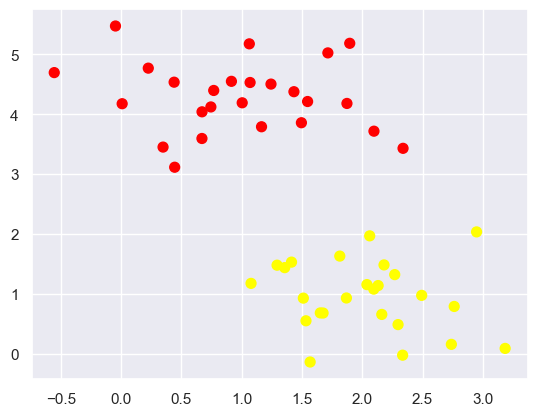

In [6]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Un clasificador discriminativo lineal intentaría trazar una línea recta que separe los dos conjuntos de datos y, así, crear un modelo para la clasificación. Sin embargo, surge un problema: ¡hay más de una línea divisoria posible que pueda discriminar perfectamente entre las dos clases!

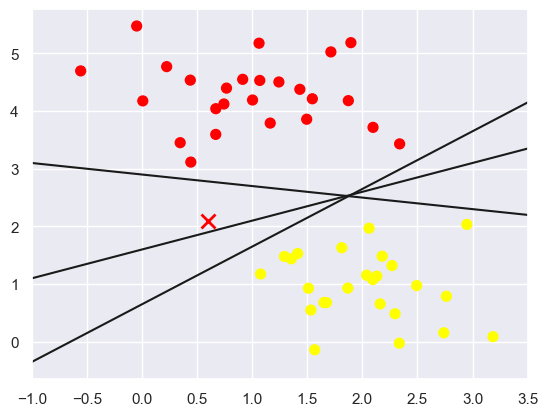

In [7]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Resumen: Estas son tres separadores muy diferentes que, sin embargo, discriminan perfectamente entre estas muestras. ¡Dependiendo de cuál elijas, un nuevo punto de datos (por ejemplo, el marcado por la "X" en este gráfico) se asignará una etiqueta diferente! Evidentemente, nuestra simple intuición de "dibujar una línea entre clases" no es suficiente, y necesitamos pensar un poco más profundamente

---

Las máquinas de vectores de soporte ofrecen una manera de mejorar esto. La intuición es la siguiente: en lugar de simplemente dibujar una línea de ancho cero entre las clases, podemos dibujar alrededor de cada línea un margen de algún ancho, hasta el punto más cercano. Aquí tienes un ejemplo de cómo podría verse esto

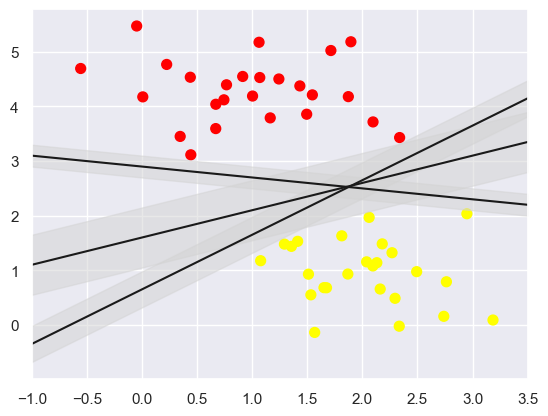

In [8]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='lightgray', alpha=0.5)

plt.xlim(-1, 3.5);

> La línea que maximiza este margen es la que elegiremos como el modelo óptimo.
---

Veamos el resultado de un ajuste real a estos datos: utilizaremos el clasificador de vectores de soporte (SVC) de Scikit-Learn para entrenar un modelo SVM con estos datos. Por el momento, utilizaremos un kernel lineal y estableceremos el parámetro C en un número muy grande (discutiremos el significado de estos en más detalle en breve).

In [9]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')


Para visualizar mejor lo que está sucediendo aquí, creemos una función de conveniencia rápida que trazará los límites de decisión de SVM para nosotros.

In [10]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Esta es la línea divisoria que maximiza el margen entre los dos conjuntos de puntos. Observa que algunos de los puntos de entrenamiento solo tocan el margen: están marcados con un círculo en la siguiente figura. Estos puntos son los elementos pivotales de este ajuste; se conocen como los vectores de soporte y le dan nombre al algoritmo. En Scikit-Learn, las identidades de estos puntos se almacenan en el atributo support_vectors_ del clasificador.

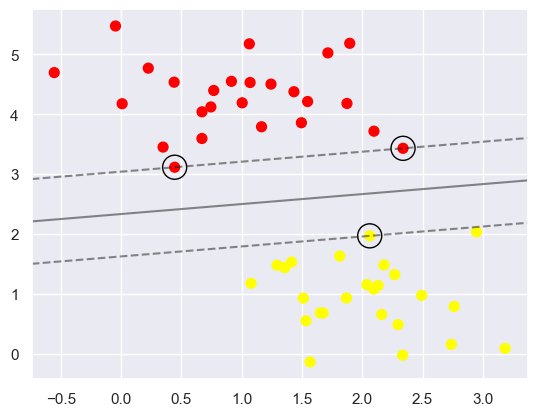

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [12]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])


Una clave para el éxito de este clasificador es que, para el ajuste, solo importan las posiciones de los vectores de soporte; cualquier punto más alejado del margen que esté en el lado correcto no modifica el ajuste. Técnicamente, esto se debe a que estos puntos no contribuyen a la función de pérdida utilizada para ajustar el modelo, por lo que su posición y número no importan siempre y cuando no crucen el margen.

Podemos ver esto, por ejemplo, si graficamos el modelo aprendido a partir de los primeros 60 puntos y los primeros 120 puntos de este conjunto de datos:

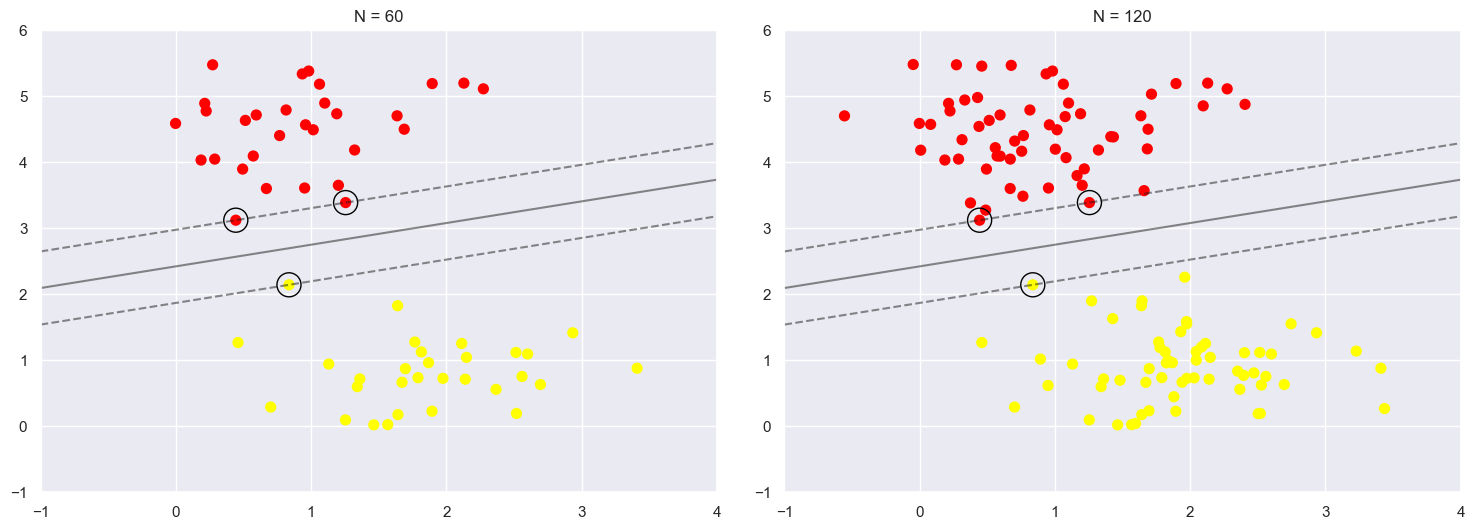

In [13]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))


> En el panel izquierdo, vemos el modelo y los vectores de soporte para 60 puntos de entrenamiento. En el panel derecho, hemos duplicado el número de puntos de entrenamiento, pero el modelo no ha cambiado: los tres vectores de soporte en el panel izquierdo son los mismos que los vectores de soporte en el panel derecho. Esta insensibilidad al comportamiento exacto de los puntos distantes es una de las fortalezas del modelo SVM.
---


Donde las SVM pueden volverse muy poderosas es cuando se combinan con kernels. Hemos visto una versión de los kernels antes, en las regresiones de funciones de base de "En Profundidad: Regresión Lineal". Allí proyectamos nuestros datos en un espacio de mayor dimensión definido por polinomios y funciones de base gaussiana, y así pudimos ajustar relaciones no lineales con un clasificador lineal.

En los modelos SVM, podemos usar una versión de la misma idea. Para motivar la necesidad de kernels, veamos algunos datos que no son linealmente separables:

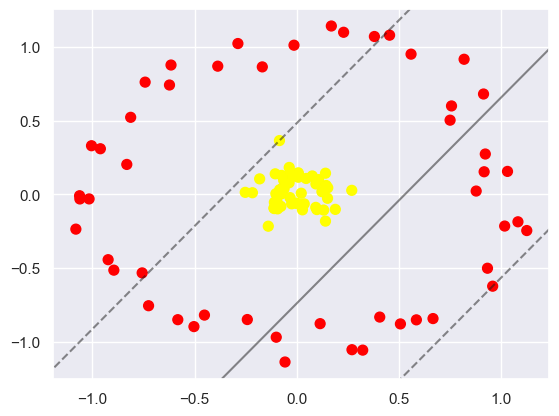

In [15]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);


Es claro que ninguna discriminación lineal podrá separar estos datos. Pero podemos extraer una lección de las regresiones de función de base en "En Profundidad: Regresión Lineal", y pensar en cómo podríamos proyectar los datos en una dimensión más alta de manera que un separador lineal sería suficiente. Por ejemplo, una proyección simple que podríamos usar sería calcular una función de base radial (RBF) centrada en el grupo medio:

In [16]:
r = np.exp(-(X ** 2).sum(1))

Podemos visualizar esta dimensión de datos adicional utilizando un gráfico tridimensional, como se ve en la siguiente figura:

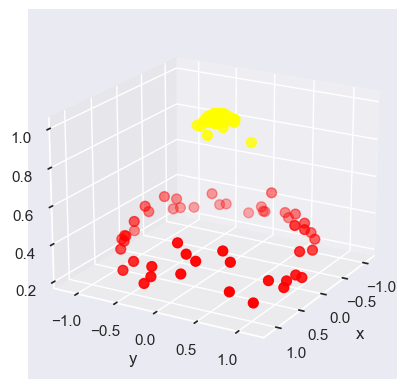

In [17]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

In [18]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

Con una dimensión adicional, los datos se vuelven fácilmente separables linealmente. Necesitamos elegir y ajustar cuidadosamente la proyección, centrando la función de base radial correctamente. Una estrategia para esto es usar transformaciones de kernel, que se basan en relaciones de similitud entre cada par de puntos. Aunque proyectar N puntos en N dimensiones puede ser computacionalmente costoso, el truco del kernel permite ajustar los datos transformados de manera implícita, sin necesidad de construir la representación completa de la proyección. Este truco es una de las razones por las que SVM es tan poderoso. En Scikit-Learn, podemos aplicar SVM con kernel simplemente cambiando el hiperparámetro del modelo de kernel.

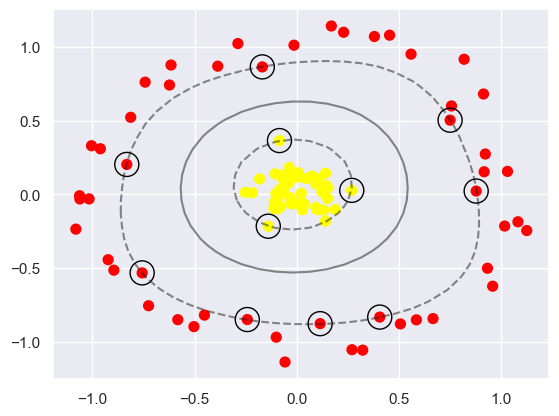

In [19]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');


Usando esta máquina de vectores de soporte con kernel, aprendemos un límite de decisión no lineal adecuado. Esta estrategia de transformación de kernel se utiliza frecuentemente en aprendizaje automático para convertir métodos lineales rápidos en métodos no lineales rápidos, especialmente para modelos en los que se puede usar el truco del kernel.

Ajuste del SVM: Suavizando los Márgenes
Nuestra discusión hasta ahora se ha centrado en conjuntos de datos muy limpios, en los que existe un límite de decisión perfecto. ¿Pero qué sucede si tus datos tienen algo de superposición? Por ejemplo, puedes tener datos como estos (ver la siguiente figura):

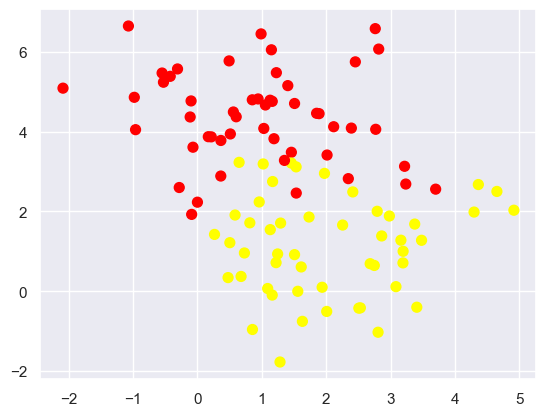

In [20]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');


Para manejar este caso, la implementación de SVM tiene un factor de ajuste que "suaviza" el margen: es decir, permite que algunos puntos se acerquen al margen si eso permite un mejor ajuste. La dureza del margen está controlada por un parámetro de ajuste, conocido comúnmente como C. Para un valor muy grande de C, el margen es duro y los puntos no pueden estar en él. Para un valor menor de C, el margen es más suave y puede crecer para incluir algunos puntos.

El gráfico mostrado en la siguiente figura ofrece una imagen visual de cómo un cambio en C afecta el ajuste final mediante el suavizado del margen:

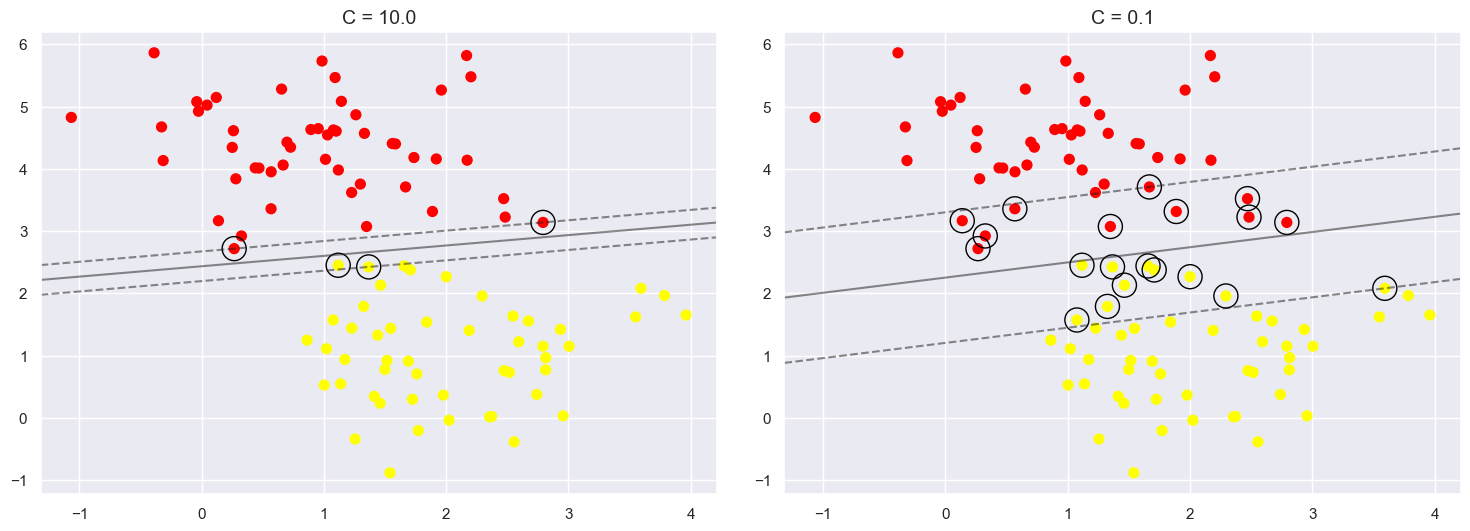

In [21]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

---

 Reconocimiento Facial
Como ejemplo del funcionamiento de las máquinas de vectores de soporte, echemos un vistazo al problema de reconocimiento facial. Utilizaremos el conjunto de datos Labeled Faces in the Wild, que consiste en varias miles de fotos recopiladas de diversas figuras públicas. Scikit-Learn incluye un cargador para este conjunto de datos:

In [22]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)



Tracemos algunas de estas caras para ver con qué estamos trabajando:

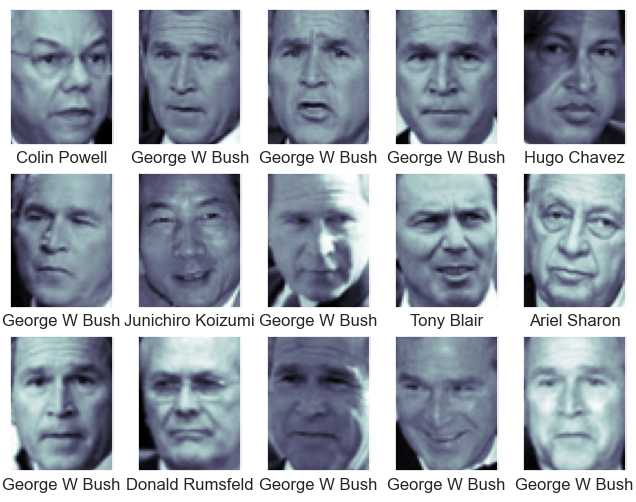

In [23]:
fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagen contiene 62 × 47, o alrededor de 3,000 píxeles. Podríamos proceder simplemente usando el valor de cada píxel como una característica, pero a menudo es más efectivo usar algún tipo de preprocesador para extraer características más significativas; aquí usaremos el análisis de componentes principales (ver "En Profundidad: Análisis de Componentes Principales") para extraer 150 componentes fundamentales para alimentar nuestro clasificador de máquina de vectores de soporte. Podemos hacer esto de manera más directa empaquetando el preprocesador y el clasificador en un solo pipeline:

In [24]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Para probar la salida de nuestro clasificador, dividiremos los datos en un conjunto de entrenamiento y un conjunto de pruebas:

In [25]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)


Finalmente, podemos usar la búsqueda de cuadrícula con validación cruzada para explorar combinaciones de parámetros. Aquí ajustaremos C (que controla la dureza del margen) y gamma (que controla el tamaño del kernel de función de base radial) y determinaremos el mejor modelo:

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 2min 37s
Wall time: 1min
{'svc__C': 5, 'svc__gamma': 0.001}



Los valores óptimos se encuentran hacia el centro de nuestra cuadrícula; si se encontraran en los extremos, querríamos expandir la cuadrícula para asegurarnos de haber encontrado el verdadero óptimo.

Ahora, con este modelo validado cruzadamente, podemos predecir las etiquetas para los datos de prueba, que el modelo aún no ha visto:

In [27]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

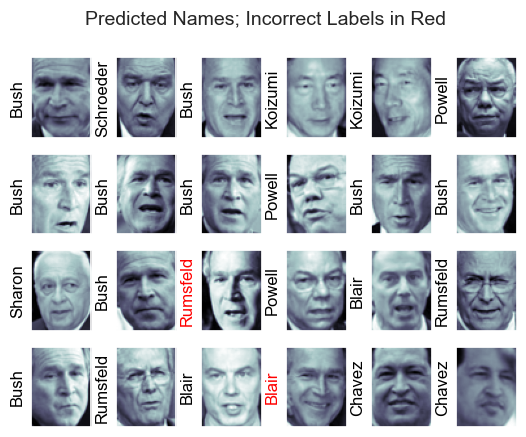

In [28]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);


De esta pequeña muestra, nuestro estimador óptimo etiquetó incorrectamente solo una cara (la cara de Bush en la última fila fue etiquetada incorrectamente como Blair). Podemos obtener una mejor idea del rendimiento de nuestro estimador utilizando el informe de clasificación, que enumera las estadísticas de recuperación etiqueta por etiqueta:

In [29]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



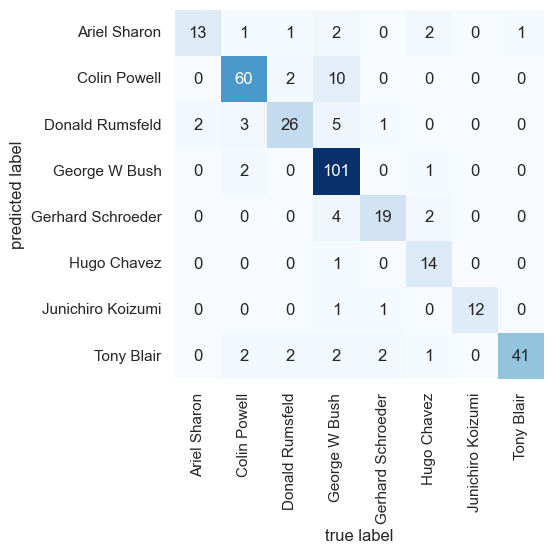

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Esto nos ayuda a tener una idea de qué etiquetas son propensas a ser confundidas por el estimador.

Para una tarea de reconocimiento facial del mundo real, en la que las fotos no vienen pre-recortadas en cuadrículas ordenadas, la única diferencia en el esquema de clasificación facial es la selección de características: tendrías que usar un algoritmo más sofisticado para encontrar las caras y extraer características que sean independientes de la pixelación. Para este tipo de aplicación, una buena opción es hacer uso de OpenCV, que incluye, entre otras cosas, implementaciones preentrenadas de herramientas de extracción de características de vanguardia para imágenes en general y caras en particular.


> Resumen
Esta ha sido una breve introducción intuitiva a los principios detrás de las máquinas de vectores de soporte. Estos modelos son un método de clasificación poderoso, por varias razones:

Su dependencia de relativamente pocos vectores de soporte significa que son compactos y ocupan muy poca memoria.

Una vez que el modelo está entrenado, la fase de predicción es muy rápida.

Debido a que solo se ven afectados por puntos cerca del margen, funcionan bien con datos de alta dimensión, incluso con más dimensiones que muestras, lo cual es desafiante para otros algoritmos.

Su integración con métodos de kernel los hace muy versátiles, capaces de adaptarse a muchos tipos de datos.
Sin embargo, las SVM también tienen varias desventajas:

La escalabilidad con el número de muestras N es O[N3] en el peor de los casos, o O[N2] para implementaciones eficientes. Para grandes cantidades de muestras de entrenamiento, este costo computacional puede ser prohibitivo.

Los resultados dependen fuertemente de una elección adecuada para el parámetro de suavizado C. Esto debe ser elegido cuidadosamente mediante validación cruzada, lo que puede ser costoso a medida que los conjuntos de datos crecen en tamaño.

Los resultados no tienen una interpretación probabilística directa. Esto puede estimarse mediante una validación cruzada interna (consultar el parámetro de probabilidad de SVC), pero esta estimación adicional es costosa.

Con esas características en mente, generalmente solo recurro a las SVM una vez que otros métodos más simples, rápidos y menos intensivos en ajustes han demostrado ser insuficientes para mis necesidades. Sin embargo, si tienes los ciclos de CPU para comprometerte con el entrenamiento y la validación cruzada de una SVM en tus datos, el método puede llevar a resultados excelentes.